### Setup

In [ ]:
import os
os.chdir('../')
os.getcwd()

In [ ]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
 
from production_code import constants
from production_code import haar

In [ ]:
signal = pd.read_excel('data/eurusd.xlsx')

In [4]:
signal.head()

,Date,PX_LAST
0,2020-04-03,1.0801
1,2020-04-02,1.0858
2,2020-04-01,1.0964
3,2020-03-31,1.1031
4,2020-03-30,1.1048


In [5]:
signal = signal.loc[signal["Date"] <= constants.NON_POW_END_DATE]
signal = signal.loc[signal["Date"] >= constants.NON_POW_START_DATE]
signal = signal["PX_LAST"].to_numpy()

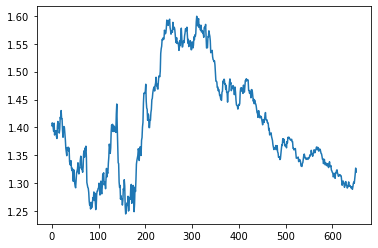

In [6]:
plt.plot(signal)

In [7]:
# Take greatest power of two last observations
k = len(signal)
while not (math.log2(k).is_integer()):
    k -= 1
signal = signal[len(signal) - k:]

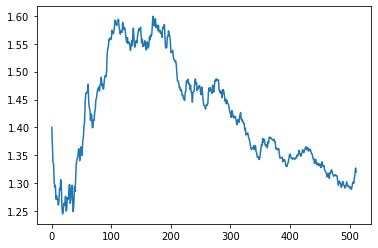

In [8]:
plt.plot(signal)

### Denoise the signal

In [9]:
from production_code.haar import Haar

In [10]:
haar = Haar()

In [11]:
WT = haar.forward(signal)

<b> Estimate the noise variance </b>

In [12]:
max_scale = max([x[0] for x in WT.keys()])
wvlt_coeffs_max_scale = [v for (k,v) in WT.items() if k[0]==max_scale]

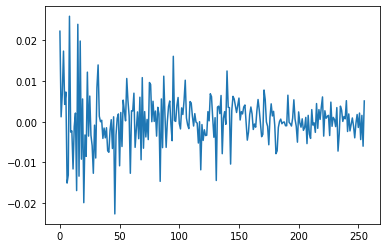

In [13]:
plt.plot(wvlt_coeffs_max_scale)

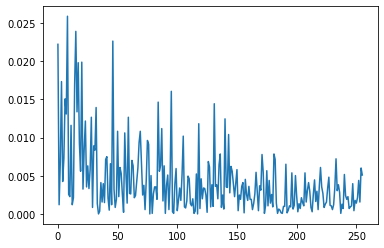

In [14]:
plt.plot([abs(x) for x in wvlt_coeffs_max_scale])

In [15]:
# Estimate the median of the absolute value of a N(0,1) variable
normal = np.random.normal(0,1,1000000)
median_abs_normal = np.median(abs(normal))

In [16]:
sigma_estimate = np.median([abs(x) for x in wvlt_coeffs_max_scale]) / median_abs_normal

In [17]:
f"{sigma_estimate * 100:.4f}%"

'0.4354%'

<b> Compute universal threshold </b>

In [18]:
def estimate_noise_variace(WT: dict) -> float:
    max_scale = max([x[0] for x in WT.keys()])
    wvlt_coeffs_max_scale = [v for (k,v) in WT.items() if k[0]==max_scale]
    
    normal = np.random.normal(0,1,1000000)
    median_abs_normal = np.median(abs(normal))
    
    return np.median([abs(x) for x in wvlt_coeffs_max_scale]) / median_abs_normal

In [19]:
def compute_universal_threshold(WT: dict, T: int) -> float:
    noise_variance = estimate_noise_variace(WT)
    return pow(2 * np.log(T), 0.5) * noise_variance

In [20]:
univ_threshold = compute_universal_threshold(WT, len(signal))

In [21]:
WT_univ = haar.suppress(WT, univ_threshold)

In [22]:
signal_univeral_threshold = haar.backwards(WT_univ)

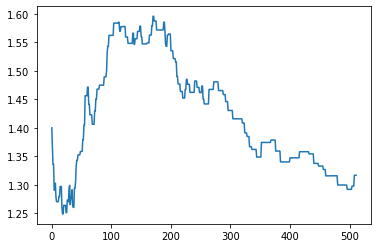

In [23]:
plt.plot(signal_univeral_threshold)

<b> Méthode Garcin p.120 SUREShrink </b>

In [24]:
def __compute_sure_val_g(y: float, sigma: float, threshold: float) -> float:
    if abs(y) >= threshold:
        return pow(threshold, 2) + pow(sigma, 2)
    return pow(y, 2) - pow(sigma, 2)

__vcompute_sure_val_g = np.vectorize(__compute_sure_val_g)

def SURE_G(coeffs: list, threshold: float, sigma) -> float:
    return np.sum(__vcompute_sure_val_g(coeffs, threshold, sigma))

In [25]:
SURE_G(wvlt_coeffs_max_scale, univ_threshold, sigma_estimate)

-0.01592960501367424

In [26]:
all_thresholds = np.linspace(0, univ_threshold, 100)

In [27]:
all_SURE_G = [SURE_G(wvlt_coeffs_max_scale, x, sigma_estimate) for x in all_thresholds]

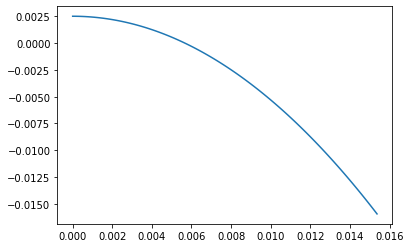

In [28]:
plt.plot(all_thresholds, all_SURE_G)

In [29]:
all_scales = set(k[0] for (k,v) in WT.items())

In [30]:
SURE_all_scales = dict()
for j in all_scales:
    wavelet_coeffs = [v for (k,v) in WT.items() if k[0]==j]
    SURE_all_scales.update({j:[SURE_G(wavelet_coeffs, x, sigma_estimate) for x in all_thresholds]})

<b> Article SUREShrink </b>

In [58]:
def __count_below_thresh(ts: list, threshold:float) -> int:
    ''' Second part equation 18 in article
    '''
    return sum([1 if abs(x) <= threshold else 0 for x in ts])

def __sum_min_thresh(ts: list, threshold: float) -> float:
    ''' Third part equation (18) in article
    '''
    return sum([pow(min(abs(x), threshold),2) for x in ts])

def SURE(ts: list, threshold: float, T: int) -> float:
    ''' Equation (18) in article
    '''
    return T - __count_below_thresh(ts, threshold) + __sum_min_thresh(ts, threshold)

def __use_universal_threshold(ts: list) -> bool:
    ''' Condition (19) article page 11
    '''
    left = sum([pow(x,2) - 1 for x in ts])
    right = np.log2(pow(len(ts), 1.5))
    return left <= right

In [59]:
def compute_SURE_threshold(ts: list, universal_threshold: float, T: int) -> float:
    ''' Equation (17) page 11 article
    '''
    all_thresholds = np.linspace(0, universal_threshold, 1000)
    all_SURE_scores = [SURE(ts, x, T) for x in all_thresholds]
    min_idx = np.argmin(all_SURE_scores)
    return all_thresholds[min_idx]

def compute_SURE_Shrink_threshold(scale_coeffs: list, universal_threshold: float, T: int) -> float:
    ''' Article page 11
    '''    
    if __use_universal_threshold(scale_coeffs):
        return universal_threshold
    else:
        return compute_SURE_threshold(scale_coeffs, universal_threshold, T)

In [60]:
def __suppress_by_scale(ts: list, threshold: float, method: str='hard'):
    ''' Applies the thresholding as specified page 10 in article for a given time-series
    '''
    if method=='hard':
        return [x if abs(x) > threshold else 0 for x in ts]
    elif method=='soft':
        return [np.sign(x) * (abs(x) - threshold) if abs(x) > threshold else 0 for x in ts]
    return

In [68]:
def denoise_coefficients(WT: dict, universal_threshold: float, method: str='hard'):
    all_scales = set(k[0] for (k,v) in WT.items())
    WT_denoised = dict()
    T = 2*max(all_scales)
    for scale in all_scales:
        scale_coefficients = [v for (k, v) in WT.items() if k[0]==scale]
        threshold = compute_SURE_Shrink_threshold(scale_coefficients, universal_threshold, T)
        scale_coefficients = __suppress_by_scale(scale_coefficients, threshold, method)
        WT_denoised.update({(scale, i):val for i, val in enumerate(scale_coefficients)})
    return WT_denoised

In [81]:
WT_denoised = denoise_coefficients(WT, univ_threshold, 'soft')

In [82]:
denoised_signal = haar.backwards(WT_denoised)

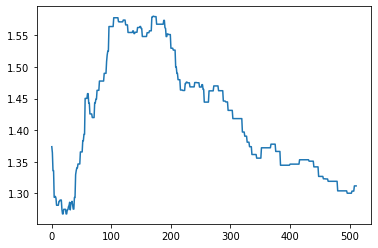

In [83]:
plt.plot(denoised_signal)

### Test production code

In [12]:
from production_code.denoising import SUREShrink

In [13]:
denoiser = SUREShrink()

In [14]:
WT_denoised = denoiser.denoise_coefficients(WT, 'soft')

In [15]:
denoised_signal = haar.backwards(WT_denoised)

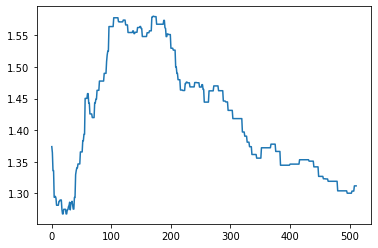

In [16]:
plt.plot(denoised_signal)

In [17]:
from production_code.denoising import SURE

In [18]:
sure = SURE()

In [22]:
WT_sure = sure.denoise_coefficients(WT,'soft')

In [23]:
denoised_signal = haar.backwards(WT_sure)

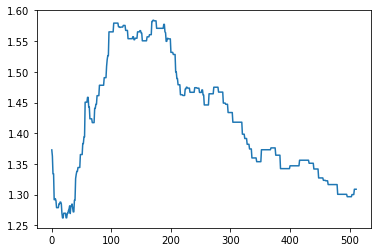

In [24]:
plt.plot(denoised_signal)